In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# IMPORTACION LIBRERIAS

In [ ]:
!pip install pyecharts
from pyecharts.charts import Bar
from pyecharts import options as opts
import IPython
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import accuracy_score,mean_absolute_error,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
import missingno as msno

# CARGADO DE DATOS


In [ ]:
# Dataset entrenamiento
df_train = pd.read_csv('/content/drive/MyDrive/Máster Universitario en Análisis de Grandes Cantidades de Datos - MBI  Big Data Analytics/GRUPO/ApredizajeAutomatico/Practica final/ames-dataset/train.csv')

# Dataset validacion
df_val = pd.read_csv('/content/drive/MyDrive/Máster Universitario en Análisis de Grandes Cantidades de Datos - MBI  Big Data Analytics/GRUPO/ApredizajeAutomatico/Practica final/ames-dataset/test.csv')

# TRATAMIENTO DE DATOS PARA EL ENTRENAMIENTO

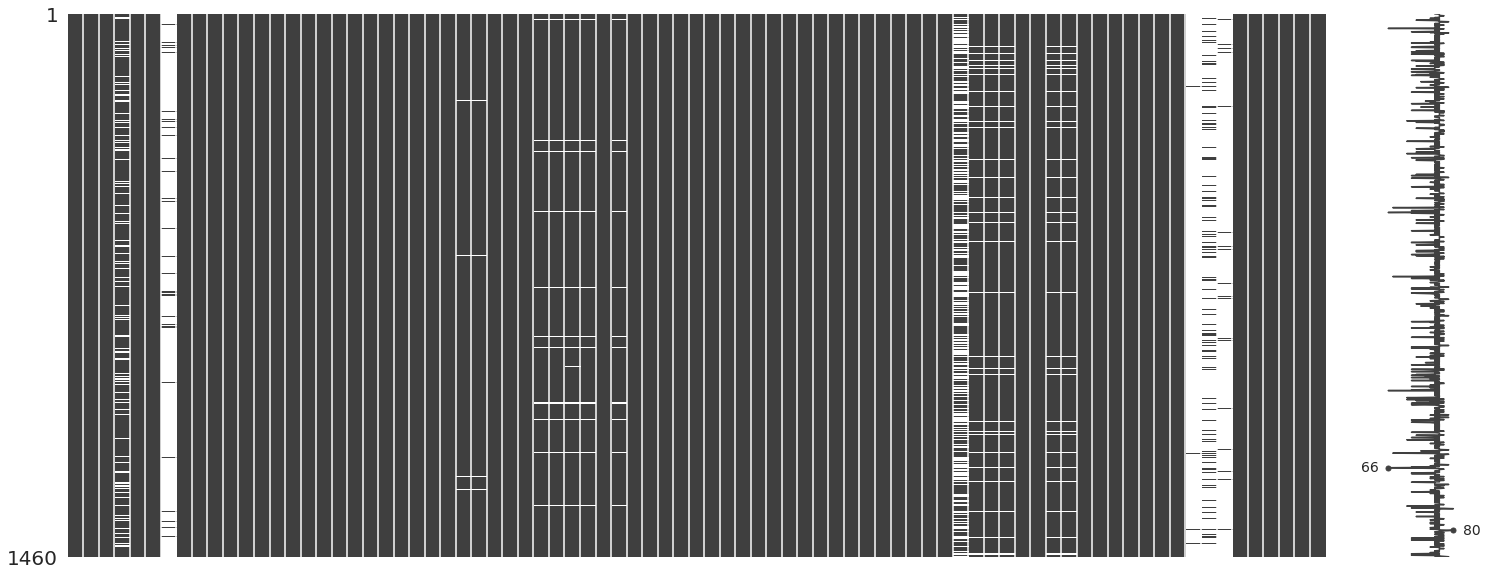

In [ ]:
%matplotlib inline
msno.matrix(df_train)

## 1.1 Obtencion de las columnas del dataset

In [ ]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 1.2 Estudio Outlayers

Según el documento adjunto, se propone eliminar las casas con GR LIVE AREA por encima de los 1500 pies cuadrados 

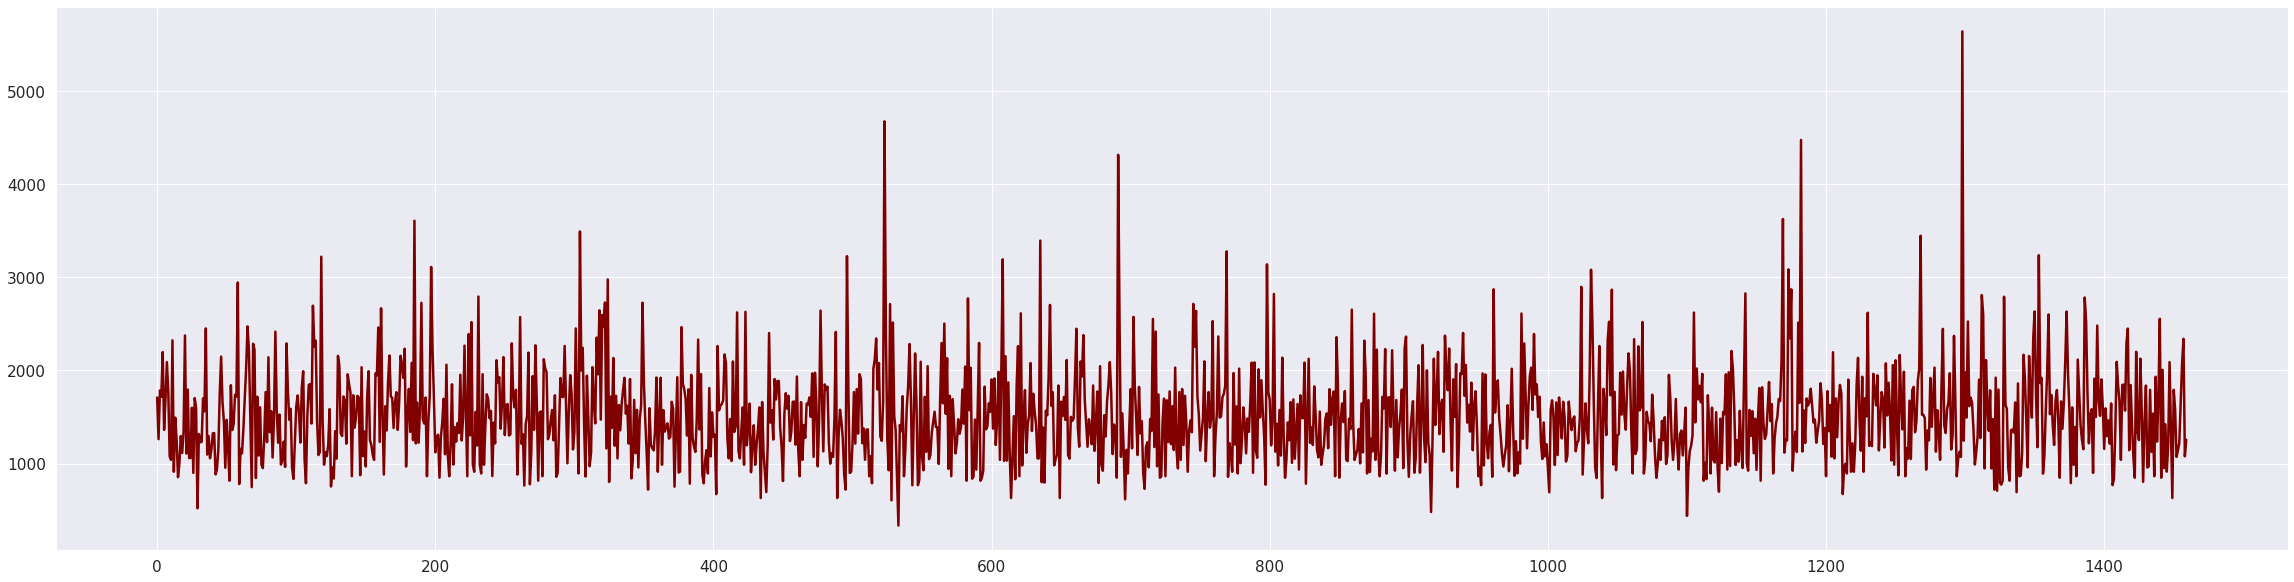

In [ ]:
sns.set(font_scale=1.4)
df_train['GrLivArea'].plot(figsize=(40, 10), linewidth=2.5, color='maroon')

Se realiza una grafica de vela para observar los outlayers 

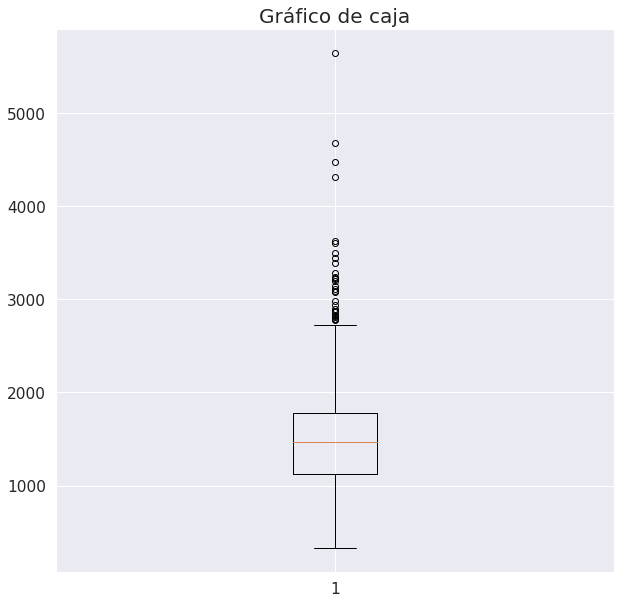

<Figure size 432x288 with 0 Axes>

In [ ]:
# Solución
gr_liv_area = df_train['GrLivArea']
plt.figure(figsize=(10,10))
plt.title('Gráfico de caja',fontdict={'fontsize': 20.0})
plt.boxplot(gr_liv_area)
plt.show()
plt.clf()

Mediante la siguiente fila obtenemos el valor de los rangos en los que se encuentran los outlayers

In [ ]:
df_train["GrLivArea"].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

In [ ]:
#LO QUE DICE LA FÓRMULA DE LOS OUTLIERS
rangoInter = 2500-1129
df_train["GrLivArea"]
df_train[(df_train["GrLivArea"] < 1 - 1.5 * rangoInter) | (df_train["GrLivArea"] > 2 + rangoInter * 1.5)]["GrLivArea"].count()

190

## 1.3 Obtencion de los valores NA

In [ ]:
df_train_nan = df_train.isna().sum().sort_values(ascending=False).to_frame().rename(columns = {0:'NAN'})
df_train_nan.head(20)

,NAN
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageCond,81
GarageType,81
GarageYrBlt,81
GarageFinish,81


## 1.4 Obtencion de los valores NULL

In [ ]:
df_train_null = df_train.isnull().sum().sort_values(ascending=False).to_frame().rename(columns = {0:'NULL'})
df_train_null.head(20)

,NULL
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageCond,81
GarageType,81
GarageYrBlt,81
GarageFinish,81


Se ha copmprobado los valores NA y NULL y se ha visto que son exactamente los mismos.

## 1.4 Numero de filas totales

In [ ]:
rows = df_train.count().sort_values(ascending=False).iloc[0]

Se halla el porcentaje de null/na en las columnas y despues se comparará con la correlacion para ver cuales se pueden descartar y cuales hay que arreglar

In [ ]:
null_percentage = (df_train_null.NULL / rows) * 100
null_percentage.head(20)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Utilities        0.000000
Name: NULL, dtype: float64

## 1.6 Muestra de la correlacion entre las columnas

In [ ]:
df_train.corr(method = "pearson").unstack().sort_values(ascending = False).drop_duplicates().head(20)

SalePrice     SalePrice       1.000000
GarageCars    GarageArea      0.882475
GarageYrBlt   YearBuilt       0.825667
GrLivArea     TotRmsAbvGrd    0.825489
1stFlrSF      TotalBsmtSF     0.819530
SalePrice     OverallQual     0.790982
GrLivArea     SalePrice       0.708624
              2ndFlrSF        0.687501
BedroomAbvGr  TotRmsAbvGrd    0.676620
BsmtFinSF1    BsmtFullBath    0.649212
GarageYrBlt   YearRemodAdd    0.642277
SalePrice     GarageCars      0.640409
FullBath      GrLivArea       0.630012
GarageArea    SalePrice       0.623431
TotRmsAbvGrd  2ndFlrSF        0.616423
TotalBsmtSF   SalePrice       0.613581
2ndFlrSF      HalfBath        0.609707
1stFlrSF      SalePrice       0.605852
GarageCars    OverallQual     0.600671
GrLivArea     OverallQual     0.593007
dtype: float64

Se observa que las columnas :




    * PoolQC          99.520548
    * MiscFeature     96.301370
    * Alley           93.767123
    * Fence           80.753425
    * FireplaceQu     47.260274
    * LotFrontage     17.739726
No estan en la correlacion de mas del 0.5%, por lo que las descartaremos en nuestro proceso.

El resto de columnas que tienen algun porcentaje de null/na las rellenaremos mediante la media del resto de los datos de cada columna.

## 1.7 Borramos las columnas que no vamos a necesitar

In [ ]:
df_train_limpio = df_train.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'])

## 1.8 Sustituir valores na/null 

In [ ]:
#Columnas que voy a reemplazar
#Estas columnas de la media solo podrán ser numéricas
col_for_mean = []
col_for_mode = []
for column in df_train_limpio.columns:
  if str(df_train_limpio[column].dtype) == 'int64' or str(df_train_limpio[column].dtype) =='float64':
    col_for_mean.append(column)
  else:
    col_for_mode.append(column)

### 1.8.1 Variable categorica --> Moda

In [ ]:
#REEMPLAZO POR LA MODA
#Columnas a reemplazar
for col in col_for_mode:
  moda = df_train_limpio[col].mode()
  for item in moda:
    if item != None and item != 'None':
        #print(item)
        df_train_limpio[col] = df_train_limpio[col].fillna(item)
        break

### 1.8.2 Variable numerica --> Media

In [ ]:
#REEMPLAZO POR LA MEDIA
#Columnas a reemplazar
for col in col_for_mean:
  media = df_train_limpio[col].mean()
  #print(media)
  df_train_limpio[col] = df_train_limpio[col].fillna(media)

# PROCESADO DE LOS DATOS

## 2.1 Definimos la variable objetivo

In [ ]:
target = df_train_limpio['SalePrice']

### 2.1.1 Borramos la variable objetivo del dataframe

In [ ]:
del df_train_limpio['SalePrice']

In [ ]:
df_train_preprocessed = df_train_limpio.copy()

### 2.1.2 Sustituimos los valores que quedan podrian quedar sueltos en caso de ser NA / NULL por su correspondiente

In [ ]:
for column in df_train_preprocessed.columns:

  if df_train_preprocessed[column].dtype == "object":
    df_train_preprocessed[column] = df_train_preprocessed[column].replace(np.nan, 'None')
  elif df_train_preprocessed[column].dtype == "float64":
    df_train_preprocessed[column] = df_train_preprocessed[column].replace(np.nan, 0.0)
  elif df_train_preprocessed[column].dtype == "int64":
    df_train_preprocessed[column] = df_train_preprocessed[column].replace(np.nan, 0)


## 2.2 Correccion de columnas

### 2.2.1 Label encoder de variables

In [ ]:
labelencoder = LabelEncoder()

df_proc = df_train_preprocessed.copy()
for column in df_proc.columns:

  if df_proc[column].dtype == "object":
    df_proc[column]=labelencoder.fit_transform(df_proc[column])

df_final = df_proc.copy()

In [ ]:
data_train, data_test, target_train, target_test = train_test_split(df_final, target, test_size=0.3, random_state=23)

In [ ]:
df_final

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,3,8450,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706,5,0,150,856,1,0,1,4,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,1,2003.0,1,2,548,4,4,2,0,61,0,0,0,0,0,2,2008,8,4
1,2,20,3,9600,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978,5,0,284,1262,1,0,1,4,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,1,1976.0,1,2,460,4,4,2,298,0,0,0,0,0,0,5,2007,8,4
2,3,60,3,11250,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,3,2,2,486,5,0,434,920,1,0,1,4,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,1,2001.0,1,2,608,4,4,2,0,42,0,0,0,0,0,9,2008,8,4
3,4,70,3,9550,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,3,1,3,0,216,5,0,540,756,1,2,1,4,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,5,1998.0,2,3,642,4,4,2,0,35,272,0,0,0,0,2,2006,8,0
4,5,60,3,14260,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,3,0,2,655,5,0,490,1145,1,0,1,4,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,1,2000.0,1,3,836,4,4,2,192,84,0,0,0,0,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,7917,1,3,3,0,4,0,8,2,2,0,5,6,5,1999,2000,1,1,12,13,2,0.0,3,4,2,2,3,3,5,0,5,0,953,953,1,0,1,4,953,694,0,1647,0,0,2,1,3,1,3,7,6,1,1,1999.0,1,2,460,4,4,2,0,40,0,0,0,0,0,8,2007,8,4
1456,1457,20,3,13175,1,3,3,0,4,0,14,2,2,0,2,6,6,1978,1988,1,1,9,10,3,119.0,3,4,1,2,3,3,0,790,4,163,589,1542,1,4,1,4,2073,0,0,2073,1,0,2,0,3,1,3,7,2,2,1,1978.0,2,2,500,4,4,2,349,0,0,0,0,0,0,2,2010,8,4
1457,1458,70,3,9042,1,3,3,0,4,0,6,2,2,0,5,7,9,1941,2006,1,1,5,5,2,0.0,0,2,4,3,1,3,2,275,5,0,877,1152,1,0,1,4,1188,1152,0,2340,0,0,2,0,4,1,2,9,6,2,1,1941.0,1,1,252,4,4,2,0,60,0,0,0,0,2500,5,2010,8,4
1458,1459,20,3,9717,1,3,3,0,4,0,12,2,2,0,2,5,6,1950,1996,3,1,8,8,2,0.0,3,4,1,3,3,2,2,49,4,1029,0,1078,1,2,1,0,1078,0,0,1078,1,0,1,0,2,1,2,5,6,0,1,1950.0,2,1,240,4,4,2,366,0,112,0,0,0,0,4,2010,8,4


## 2.3 Creacion Pipeline

### 2.3.1 Algoritomo de regresión: Random Forest Regressor

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

model_seleccion = SelectKBest(chi2, k=20)
classifier=RandomForestRegressor(max_depth=10, random_state=7)

#CREO PIPELINE
pipeline_model = Pipeline(steps=[('selector', model_seleccion),('classifier', classifier)])

#ENTRENO PIPELINE
pipeline_model.fit(data_train, target_train)
preds = pipeline_model.predict(data_test)

rfr_k20_accuracy = mean_absolute_error(target_test, preds)
rfr_k20_score = r2_score(target_test, preds)

print("Mean absolute error: ", rfr_k20_accuracy)
print("R2 score report: ", rfr_k20_score)

Mean absolute error:  21854.211612274226
R2 score report:  0.8253802886907744


In [ ]:
np.seterr(divide='ignore', invalid='ignore')

model_seleccion = SelectKBest(chi2, k=10)
classifier=RandomForestRegressor(max_depth=10, random_state=7)

#CREO PIPELINE
pipeline_model = Pipeline(steps=[('selector', model_seleccion),('classifier', classifier)])

#ENTRENO PIPELINE
pipeline_model.fit(data_train, target_train)
preds = pipeline_model.predict(data_test)

rfr_k10_accuracy = mean_absolute_error(target_test, preds)
rfr_k10_score = r2_score(target_test, preds)

print("Mean absolute error: ", rfr_k10_accuracy)
print("R2 score report: ", rfr_k10_score)

Mean absolute error:  26995.32200749699
R2 score report:  0.7568411134290489


### 2.3.2 Algoritomo de regresión: ExtraTreesRegressor

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

model_seleccion = SelectKBest(chi2, k=20)
classifier=ExtraTreesRegressor(max_depth=10, random_state=7)

#CREO PIPELINE
pipeline_model = Pipeline(steps=[('selector', model_seleccion),('classifier', classifier)])

#ENTRENO PIPELINE
pipeline_model.fit(data_train, target_train)
preds = pipeline_model.predict(data_test)

etr_k20_accuracy = mean_absolute_error(target_test, preds)
etr_k20_score = r2_score(target_test, preds)

print("Mean absolute error: ", etr_k20_accuracy)
print("R2 score report: ", etr_k20_score)

Mean absolute error:  21933.256061288514
R2 score report:  0.8228890126358086


In [ ]:
np.seterr(divide='ignore', invalid='ignore')

model_seleccion = SelectKBest(chi2, k=10)
classifier=ExtraTreesRegressor(max_depth=10, random_state=7)

#CREO PIPELINE
pipeline_model = Pipeline(steps=[('selector', model_seleccion),('classifier', classifier)])

#ENTRENO PIPELINE
pipeline_model.fit(data_train, target_train)
preds = pipeline_model.predict(data_test)

etr_k10_accuracy = mean_absolute_error(target_test, preds)
etr_k10_score = r2_score(target_test, preds)

print("Mean absolute error: ", etr_k10_accuracy)
print("R2 score report: ", etr_k10_score)

Mean absolute error:  27479.586645566753
R2 score report:  0.75001019527726


### 2.3.3 Algoritomo de regresión: DecisionTreeRegressor






In [ ]:
np.seterr(divide='ignore', invalid='ignore')

model_seleccion = SelectKBest(chi2, k=20)
classifier=DecisionTreeRegressor(max_depth=10, random_state=7)

#CREO PIPELINE
pipeline_model = Pipeline(steps=[('selector', model_seleccion),('classifier', classifier)])

#ENTRENO PIPELINE
pipeline_model.fit(data_train, target_train)
preds = pipeline_model.predict(data_test)

dtr_k20_accuracy = mean_absolute_error(target_test, preds)
dtr_k20_score = r2_score(target_test, preds)

print("Mean absolute error: ", dtr_k20_accuracy)
print("R2 score report: ", dtr_k20_score)

Mean absolute error:  29226.33517371996
R2 score report:  0.6962658522411687


In [ ]:
np.seterr(divide='ignore', invalid='ignore')

model_seleccion = SelectKBest(chi2, k=10)
classifier=DecisionTreeRegressor(max_depth=10, random_state=7)

#CREO PIPELINE
pipeline_model = Pipeline(steps=[('selector', model_seleccion),('classifier', classifier)])

#ENTRENO PIPELINE
pipeline_model.fit(data_train, target_train)
preds = pipeline_model.predict(data_test)

dtr_k10_accuracy = mean_absolute_error(target_test, preds)
dtr_k10_score = r2_score(target_test, preds)

print("Mean absolute error: ", dtr_k10_accuracy)
print("R2 score report: ", dtr_k10_score)

Mean absolute error:  32303.927324092965
R2 score report:  0.6310474106846784


### 2.3.4 Algoritomo de regresión: GradientBoostingRegressor

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

model_seleccion = SelectKBest(chi2, k=20)
classifier=GradientBoostingRegressor(max_depth=10, random_state=7)

#CREO PIPELINE
pipeline_model = Pipeline(steps=[('selector', model_seleccion),('classifier', classifier)])

#ENTRENO PIPELINE
pipeline_model.fit(data_train, target_train)
preds = pipeline_model.predict(data_test)

gbr_k20_accuracy = mean_absolute_error(target_test, preds)
gbr_k20_score = r2_score(target_test, preds)

print("Mean absolute error: ", gbr_k20_accuracy)
print("R2 score report: ", gbr_k20_score)

Mean absolute error:  23734.077247810077
R2 score report:  0.7981735366402517


In [ ]:
np.seterr(divide='ignore', invalid='ignore')

model_seleccion = SelectKBest(chi2, k=10)
classifier=GradientBoostingRegressor(max_depth=10, random_state=7)

#CREO PIPELINE
pipeline_model = Pipeline(steps=[('selector', model_seleccion),('classifier', classifier)])

#ENTRENO PIPELINE
pipeline_model.fit(data_train, target_train)
preds = pipeline_model.predict(data_test)

gbr_k10_accuracy = mean_absolute_error(target_test, preds)
gbr_k10_score = r2_score(target_test, preds)

print("Mean absolute error: ", gbr_k10_accuracy)
print("R2 score report: ", gbr_k10_score)

Mean absolute error:  27833.867431267034
R2 score report:  0.745002750940305


# GRAFICA COMPARACION GRAFICOS

In [ ]:
algoritmos = ["Random Forest","Extra Trees","Decision Tree","Gradient Boosted"]


k10_error = [rfr_k10_accuracy,etr_k10_accuracy,dtr_k10_accuracy,gbr_k10_accuracy]
k10_score = [rfr_k10_score,etr_k10_score,dtr_k10_score,gbr_k10_score]
k10_error = [round(num, 2) for num in k10_error]
k10_score = [round(num, 2) for num in k10_score]

k20_error = [rfr_k20_accuracy,etr_k20_accuracy,dtr_k20_accuracy,gbr_k20_accuracy]
k20_score = [rfr_k20_score,etr_k20_score,dtr_k20_score,gbr_k20_score]
k20_error = [round(num, 2) for num in k20_error]
k20_score = [round(num, 2) for num in k20_score]

## 3.1 Grafica de Mean absolute error de los Algoritmos

In [ ]:
bar_error = (
 Bar(init_opts=opts.InitOpts())
 .add_xaxis(algoritmos)
 .add_yaxis("Error K10", k10_error)
 .add_yaxis("Error K20", k20_error)
 .set_global_opts(title_opts=opts.TitleOpts(title="Error Medio Absoluto", subtitle=""))
)
IPython.display.HTML(filename=bar_error.render())

## 3.2 Grafica de Score de los Algoritmos

In [ ]:
bar_score = (
 Bar(init_opts=opts.InitOpts())
 .add_xaxis(algoritmos)
 .add_yaxis("Score K10", k10_score)
 .add_yaxis("Score K20", k20_score)
 .set_global_opts(title_opts=opts.TitleOpts(title="Score Prediction", subtitle=""))
)
IPython.display.HTML(filename=bar_score.render())

In [ ]:
def graficar(data,algoritmo):
  ejecuciones = list(range(0,len(data)))
  bar_score = (
  Bar(init_opts=opts.InitOpts())
  .add_xaxis(ejecuciones)
  .add_yaxis("Score k20 / cv10", data)
  .set_global_opts(title_opts=opts.TitleOpts(title="Score Prediction {}".format(algoritmo), subtitle=""))
  )
  return bar_score

# COMPROBACION MEDIANTE CROSS-VALIDATION


## 4.1 Cross - Validation: Random Forest Regressor

In [ ]:
pipeline_model = Pipeline(steps=[('selector', SelectKBest(mutual_info_regression, k=20)),('classifier', RandomForestRegressor() )])

scoresRFR = cross_val_score(pipeline_model, data_test, target_test, scoring='r2', cv=10)
print("\nValidación cruzada:")
print("MEDIA:")
print(scoresRFR.mean())


Validación cruzada:
MEDIA:
0.8473458049476686


In [ ]:
data1 = [round(num, 3) for num in list(scoresRFR)]
grafica1 = graficar(data1,"Random Forest Regressor")
IPython.display.HTML(filename=grafica1.render())

## 4.2 Cross - Validation: Extra Trees Regressor

In [ ]:
pipeline_model = Pipeline(steps=[('selector', SelectKBest(mutual_info_regression, k=20)),('classifier', ExtraTreesRegressor() )])

scoresETR = cross_val_score(pipeline_model, data_test, target_test, scoring='r2', cv=10)
print("\nValidación cruzada:")
print("MEDIA:")
print(scoresETR.mean())


Validación cruzada:
MEDIA:
0.8300519653943574


In [ ]:
data2 = [round(num, 3) for num in list(scoresETR)]
grafica2 = graficar(data2,"Extra Trees Regressor")
IPython.display.HTML(filename=grafica2.render())

## 4.3 Cross - Validation: Decision Tree Regressor

In [ ]:
pipeline_model = Pipeline(steps=[('selector', SelectKBest(mutual_info_regression, k=20)),('classifier', DecisionTreeRegressor() )])

scoresDTR = cross_val_score(pipeline_model, data_test, target_test, scoring='r2', cv=10)
print("\nValidación cruzada:")
print("MEDIA:")
print(scoresDTR.mean())


Validación cruzada:
MEDIA:
0.7151738215845189


In [ ]:
data3 = [round(num, 3) for num in list(scoresDTR)]
grafica3 = graficar(data3,"Decision Tree Regressor")
IPython.display.HTML(filename=grafica3.render())

## 4.4 Cross - Validation: Gradient Boosting Regressor

In [ ]:
pipeline_model = Pipeline(steps=[('selector', SelectKBest(mutual_info_regression, k=20)),('classifier', GradientBoostingRegressor() )])

scoresGBR = cross_val_score(pipeline_model, data_test, target_test, scoring='r2', cv=10)
print("\nValidación cruzada:")
print("MEDIA:")
print(scoresGBR.mean())


Validación cruzada:
MEDIA:
0.8638985734434254


In [ ]:
data4 = [round(num, 3) for num in list(scoresDTR)]
grafica4 = graficar(data4,"Gradient Boosting Regressor")
IPython.display.HTML(filename=grafica4.render())

## 4.5 Resultados

Dados los resultados obtenidos en el cross - validation:

*   Random Forest Regressor = 0.8473458049476686
*   Extra Trees Regressor = 0.8300519653943574
*   Decision Tree Regressor = 0.7151738215845189
*   Gradient Boosting Regressor = 0.8638985734434254







# CONCLUSIONES

Podemos concluir que el algoritmo más correcto para realizar dicha predicción de precio de las casa es el **Random Forest Regressor** mediante SelectKBest (chi2, k=20) el cuál da un resultado de :


*   Mean absolute error:  21854.21

*   R2 score report:  0.825


